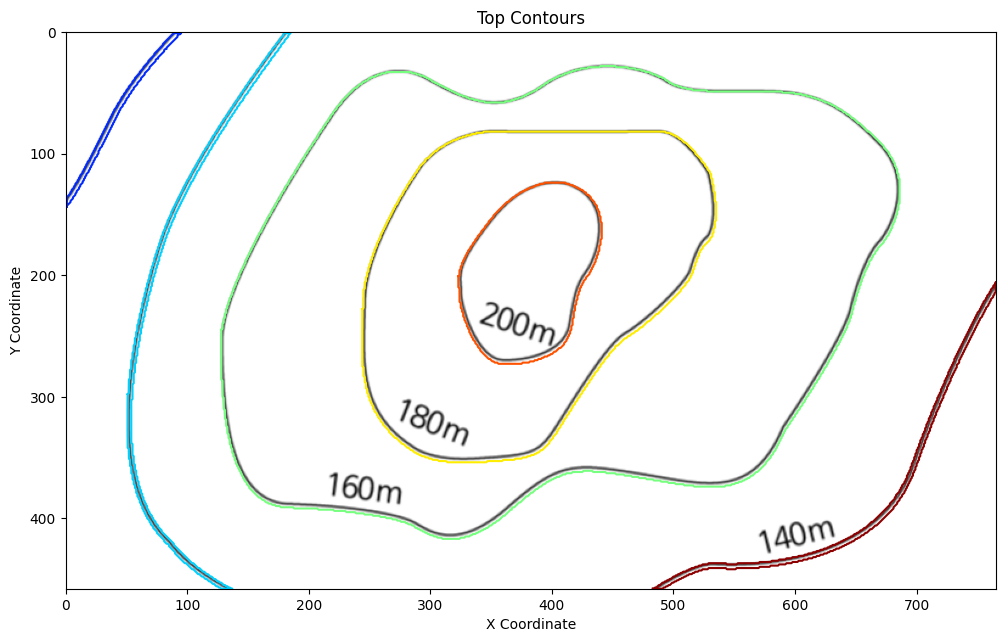

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))

    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]

    def plot(self):
        """이미지와 등고선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points)')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        #
        plt.title('Top Contours')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data_test.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.plot()  # 등고선 플롯


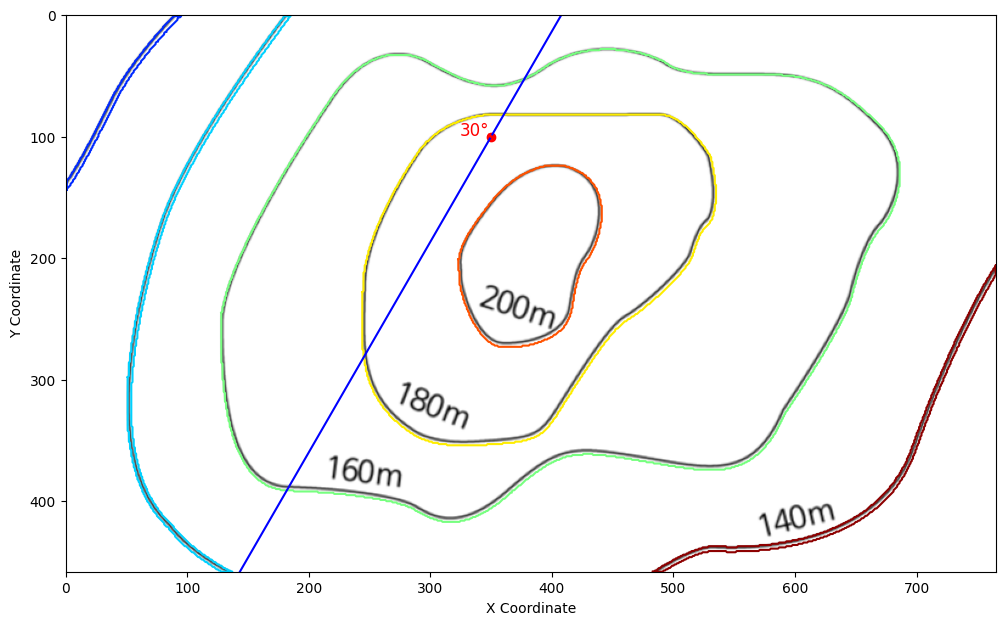

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        # 기본값을 설정하여 테스트
        self.m_x = 350.0
        self.m_y = 100.0
        self.m_h = 180.0
        self.direction = 'N30E'
        self.dip_input = '30NW'
        k = 0.3
        h = 20.0

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (h / np.tan(math.radians(self.dip_angle))) / k
    
    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        max_parallel_lines = 10  # 그릴 최대 평행 주향선 수
        for i in range(1, max_parallel_lines + 1):
            # Positive direction
            y_shifted_positive = self.y_line + i * self.del_y
            plt.plot(self.x_line, y_shifted_positive, color='blue', linestyle='--', alpha=0.7)

            # Negative direction
            y_shifted_negative = self.y_line - i * self.del_y
            plt.plot(self.x_line, y_shifted_negative, color='blue', linestyle='--', alpha=0.7)

    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points)')

        # 주향선 및 평행 주향선 그리기
        plt.plot(self.x_line, self.y_line, color='blue', label=f'Line with azimuth {self.direction}')
        self.draw_parallel_strike_lines()

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        #
        #plt.title('Top 8 Contours and Multiple Strike Lines')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data_test.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.plot()


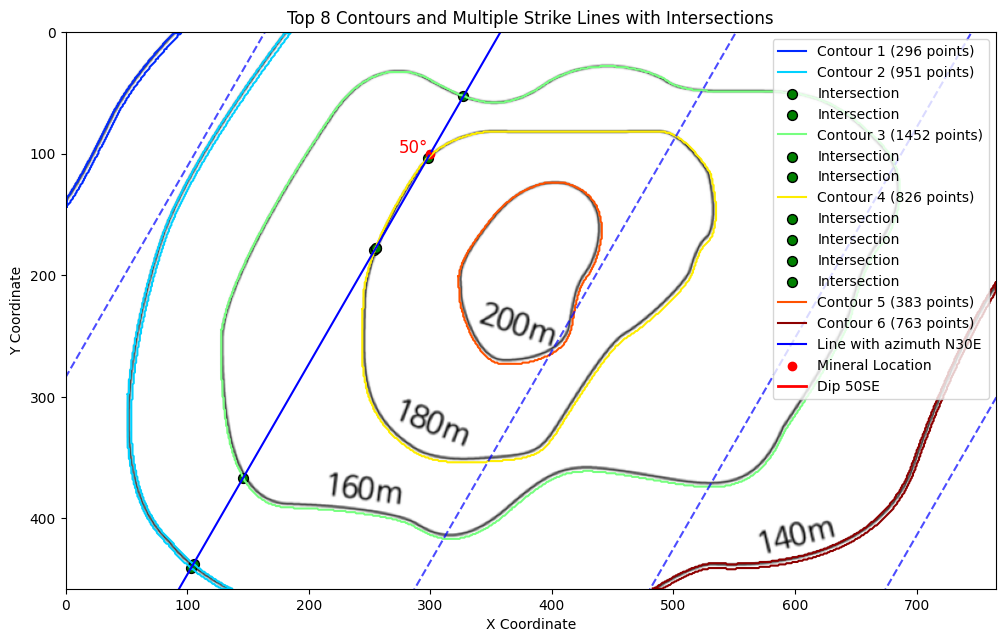

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        # 기본값을 설정하여 테스트
        self.m_x = 300.0
        self.m_y = 100.0
        self.m_h = 100.0
        self.direction = 'N30E'
        self.dip_input = '50SE'
        k = 0.1
        h = 20.0

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (h / np.tan(math.radians(self.dip_angle))) / k
    
    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        max_parallel_lines = 10  # 그릴 최대 평행 주향선 수
        for i in range(1, max_parallel_lines + 1):
            # Positive direction
            y_shifted_positive = self.y_line + i * self.del_y
            plt.plot(self.x_line, y_shifted_positive, color='blue', linestyle='--', alpha=0.7)

            # Negative direction
            y_shifted_negative = self.y_line - i * self.del_y
            plt.plot(self.x_line, y_shifted_negative, color='blue', linestyle='--', alpha=0.7)
    
    def find_intersections(self, contour_x, contour_y, line_x, line_y):
        """등고선과 주향선의 교점을 찾습니다."""
        intersections = []
        for i in range(len(contour_x) - 1):
            for j in range(len(line_x) - 1):
                # 등고선의 한 구간과 주향선의 한 구간을 고려하여 교점을 찾음
                x1, y1, x2, y2 = contour_x[i], contour_y[i], contour_x[i + 1], contour_y[i + 1]
                x3, y3, x4, y4 = line_x[j], line_y[j], line_x[j + 1], line_y[j + 1]
                denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if denom == 0:
                    continue  # 평행한 경우 교점 없음
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
                if (min(x1, x2) <= px <= max(x1, x2)) and (min(y1, y2) <= py <= max(y1, y2)) and \
                   (min(x3, x4) <= px <= max(x3, x4)) and (min(y3, y4) <= py <= max(y3, y4)):
                    intersections.append((px, py))
        return intersections
    
    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points)')

            # 교점 찾기
            intersections = self.find_intersections(x_coords, y_coords, self.x_line, self.y_line)
            for (px, py) in intersections:
                plt.scatter(px, py, color='green', s=50, edgecolor='black', label='Intersection')

        # 주향선 및 평행 주향선 그리기
        plt.plot(self.x_line, self.y_line, color='blue', label=f'Line with azimuth {self.direction}')
        self.draw_parallel_strike_lines()

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.plot()


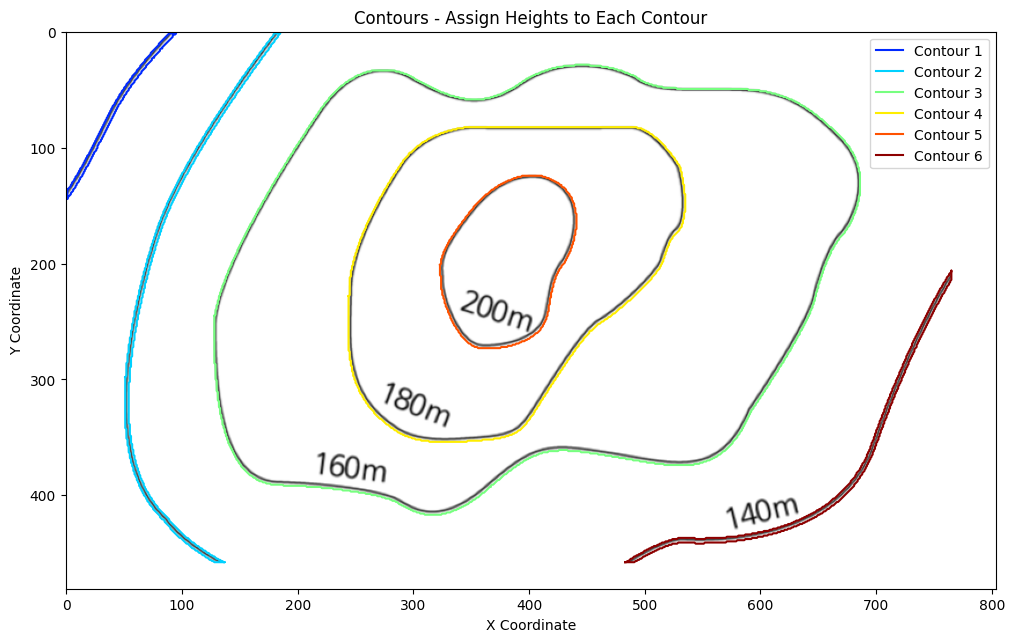

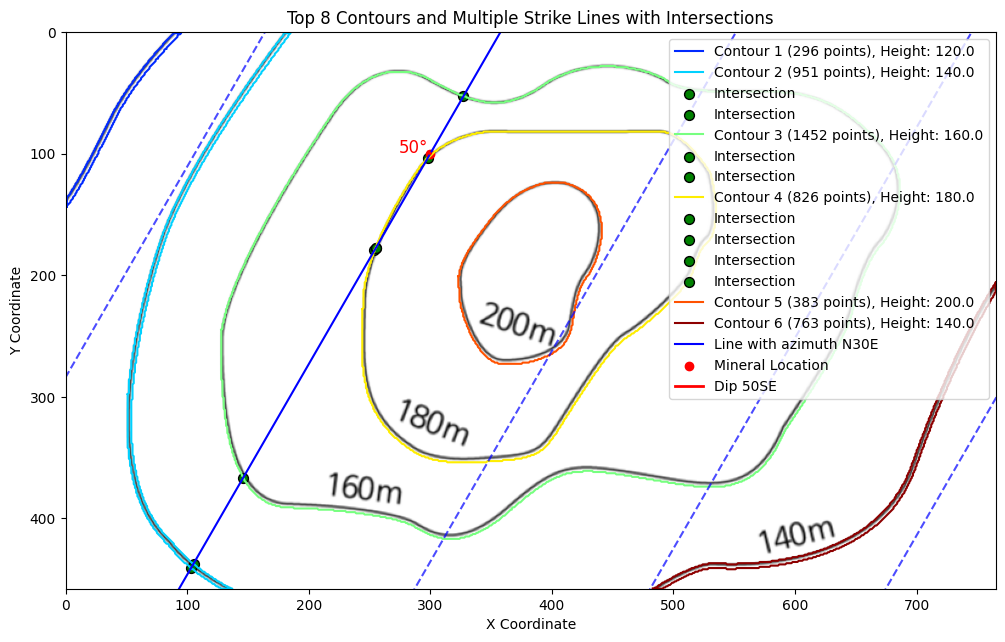

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
        self.contour_heights = {}
    
    def initialize_and_display_contours(self):
        """등고선을 초기화하고 시각화하여 높이를 설정하도록 표시합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
        
        contour_groups = self.data.groupby('Contour')
        for contour_num, group in contour_groups:
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num}')
        
        plt.title("Contours - Assign Heights to Each Contour")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()
    
    def get_contour_heights(self):
        """사용자로부터 각 등고선의 고도를 입력받습니다."""
        unique_contours = self.data['Contour'].unique()
        for contour_num in unique_contours:
            while True:
                try:
                    height = float(input(f"등고선 {contour_num}의 고도를 입력하세요: "))
                    self.contour_heights[contour_num] = height
                    break
                except ValueError:
                    print("잘못된 입력입니다. 숫자 값을 입력하세요.")
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        # 기본값을 설정하여 테스트
        self.m_x = 300.0
        self.m_y = 100.0
        self.m_h = 100.0
        self.direction = 'N30E'
        self.dip_input = '50SE'
        k = 0.1
        h = 20.0

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (h / np.tan(math.radians(self.dip_angle))) / k

        # 등고선 높이 입력
        self.get_contour_heights()
    
    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        max_parallel_lines = 10  # 그릴 최대 평행 주향선 수
        for i in range(1, max_parallel_lines + 1):
            # Positive direction
            y_shifted_positive = self.y_line + i * self.del_y
            plt.plot(self.x_line, y_shifted_positive, color='blue', linestyle='--', alpha=0.7)

            # Negative direction
            y_shifted_negative = self.y_line - i * self.del_y
            plt.plot(self.x_line, y_shifted_negative, color='blue', linestyle='--', alpha=0.7)
    
    def find_intersections(self, contour_x, contour_y, line_x, line_y):
        """등고선과 주향선의 교점을 찾습니다."""
        intersections = []
        for i in range(len(contour_x) - 1):
            for j in range(len(line_x) - 1):
                # 등고선의 한 구간과 주향선의 한 구간을 고려하여 교점을 찾음
                x1, y1, x2, y2 = contour_x[i], contour_y[i], contour_x[i + 1], contour_y[i + 1]
                x3, y3, x4, y4 = line_x[j], line_y[j], line_x[j + 1], line_y[j + 1]
                denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if denom == 0:
                    continue  # 평행한 경우 교점 없음
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
                if (min(x1, x2) <= px <= max(x1, x2)) and (min(y1, y2) <= py <= max(y1, y2)) and \
                   (min(x3, x4) <= px <= max(x3, x4)) and (min(y3, y4) <= py <= max(y3, y4)):
                    intersections.append((px, py))
        return intersections
    
    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points), Height: {self.contour_heights[contour_num]}')

            # 교점 찾기
            intersections = self.find_intersections(x_coords, y_coords, self.x_line, self.y_line)
            for (px, py) in intersections:
                plt.scatter(px, py, color='green', s=50, edgecolor='black', label='Intersection')

        # 주향선 및 평행 주향선 그리기
        plt.plot(self.x_line, self.y_line, color='blue', label=f'Line with azimuth {self.direction}')
        self.draw_parallel_strike_lines()

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.plot()


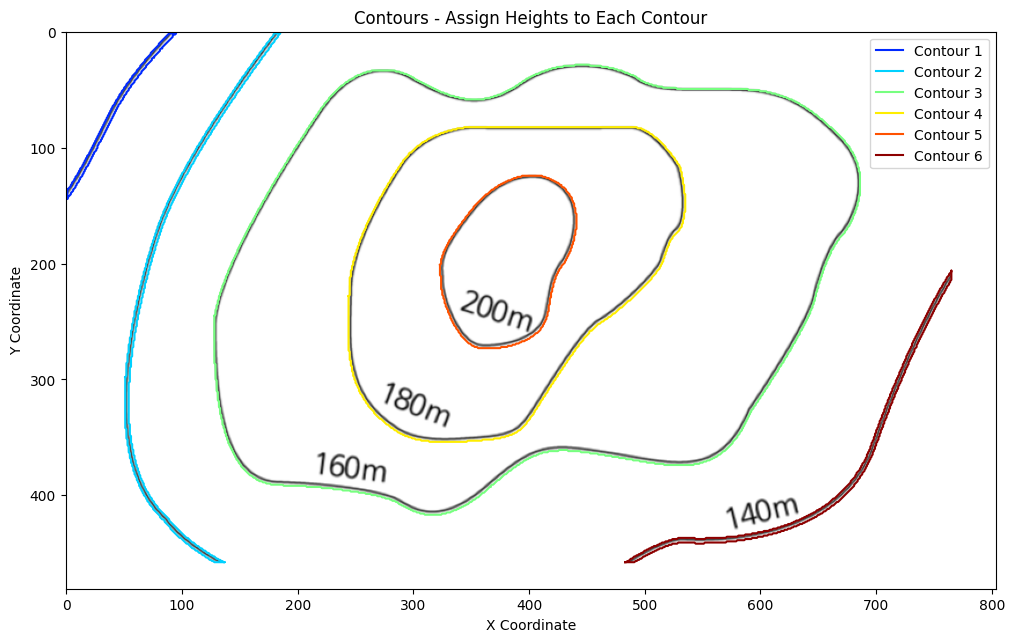

AttributeError: 'ContourPlotter' object has no attribute 'h'

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import matplotlib.cm as cm

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
        self.contour_heights = {}
        self.strike_lines = []
    
    def initialize_and_display_contours(self):
        """등고선을 초기화하고 시각화하여 높이를 설정하도록 표시합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
        
        contour_groups = self.data.groupby('Contour')
        for contour_num, group in contour_groups:
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num}')
        
        plt.title("Contours - Assign Heights to Each Contour")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()
    
    def get_contour_heights(self):
        """사용자로부터 각 등고선의 고도를 입력받습니다."""
        unique_contours = self.data['Contour'].unique()
        for contour_num in unique_contours:
            while True:
                try:
                    height = float(input(f"등고선 {contour_num}의 고도를 입력하세요: "))
                    self.contour_heights[contour_num] = height
                    break
                except ValueError:
                    print("잘못된 입력입니다. 숫자 값을 입력하세요.")
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        # 기본값을 설정하여 테스트
        self.m_x = 350.0
        self.m_y = 100.0
        self.m_h = 180.0
        self.direction = 'N30E'
        self.dip_input = '50NW'
        self.k = 0.1
        self.h = 20.0

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (self.h / np.tan(math.radians(self.dip_angle))) / self.k

    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
        self.strike_lines.append((self.x_line, self.y_line, self.m_h))
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        # 최대 평행 주향선 개수 제한 없이 그래프 범위 내에서만 그리도록 수정
        i = 1
        while True:
            # Positive direction
            current_height = self.m_h + i * self.h
            y_shifted_positive = self.y_line + i * self.del_y
            mask = (y_shifted_positive >= 0) & (y_shifted_positive <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_positive[mask], current_height))

            # Negative direction
            current_height = self.m_h - i * self.h
            y_shifted_negative = self.y_line - i * self.del_y
            mask = (y_shifted_negative >= 0) & (y_shifted_negative <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_negative[mask], current_height))
            i += 1
          
    def calculate_intersections(self):
        """주향선과 등고선의 모든 교차점을 계산하여 출력합니다."""
        self.intersections = []  # 클래스 멤버 변수로 변경
        tolerance = 1e-5  # 작은 오차 허용 범위 설정

        for contour_num, group in self.data.groupby('Contour'):
            x_coords = group['X'].values
            y_coords = group['Y'].values
            for x_line, y_line, _ in self.strike_lines:
                # 각 등고선과 주향선의 모든 교차점을 찾기
                for i in range(len(x_coords) - 1):
                    for j in range(len(x_line) - 1):
                        x1, y1, x2, y2 = x_coords[i], y_coords[i], x_coords[i + 1], y_coords[i + 1]
                        x3, y3, x4, y4 = x_line[j], y_line[j], x_line[j + 1], y_line[j + 1]

                        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                        if abs(denom) < tolerance:
                            continue  # 거의 평행한 경우 교점 없음

                        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

                        # 교차점이 두 선분의 범위 내에 있는지 확인
                        if (min(x1, x2) - tolerance <= px <= max(x1, x2) + tolerance) and \
                        (min(y1, y2) - tolerance <= py <= max(y1, y2) + tolerance) and \
                        (min(x3, x4) - tolerance <= px <= max(x3, x4) + tolerance) and \
                        (min(y3, y4) - tolerance <= py <= max(y3, y4) + tolerance):
                            self.intersections.append((contour_num, px, py))
                            # 교차점 정보를 터미널에 출력
                            print(f"Intersection at contour {contour_num}, X = {px:.2f}, Y = {py:.2f}")

    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points), Height: {self.contour_heights[contour_num]}')

        # 주향선 및 평행 주향선 그리기
        import random
        for idx, (x_line, y_line, height) in enumerate(self.strike_lines):
            random_color = (random.random(), random.random(), random.random())
            plt.plot(x_line, y_line, color=random_color, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m')

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
       # 교차점 플롯 추가
        for contour_num, x, y in self.intersections:
            plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.draw_parallel_strike_lines()  # 평행 주향선 그리기
plotter.calculate_intersections()  # 교차점 계산
plotter.plot()


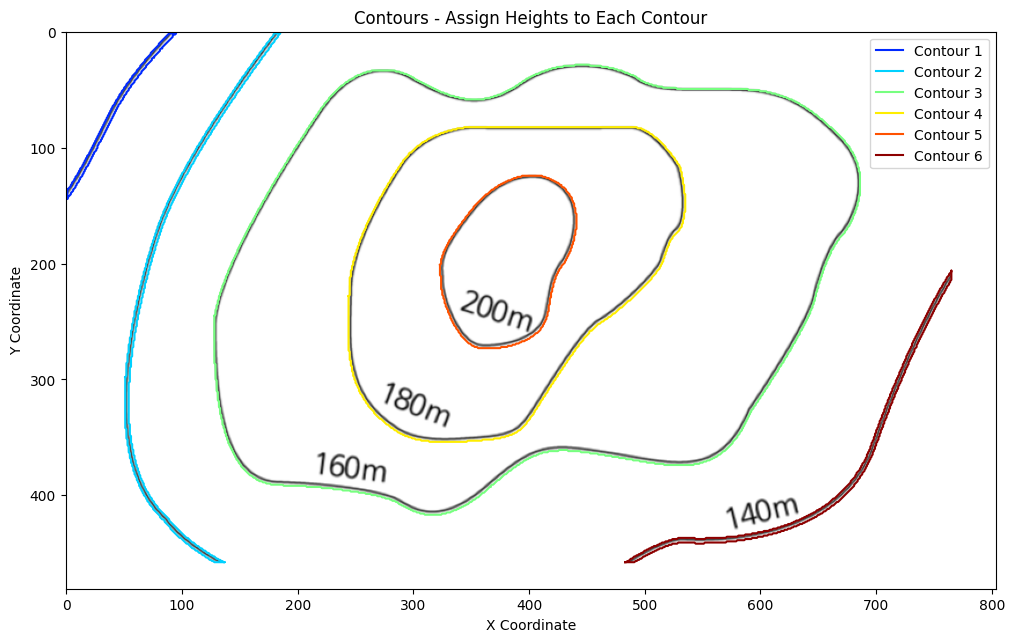

Intersection at contour 2 (height 140.0), X = 55.00, Y = 342.44
Intersection at contour 2 (height 140.0), X = 52.00, Y = 347.64
Intersection at contour 3 (height 160.0), X = 305.62, Y = 42.62
Intersection at contour 3 (height 160.0), X = 135.00, Y = 338.13
Intersection at contour 4 (height 180.0), X = 360.39, Y = 82.00
Intersection at contour 4 (height 180.0), X = 245.00, Y = 281.87
Intersection at contour 5 (height 200.0), X = 413.08, Y = 125.00
Intersection at contour 5 (height 200.0), X = 337.28, Y = 256.28


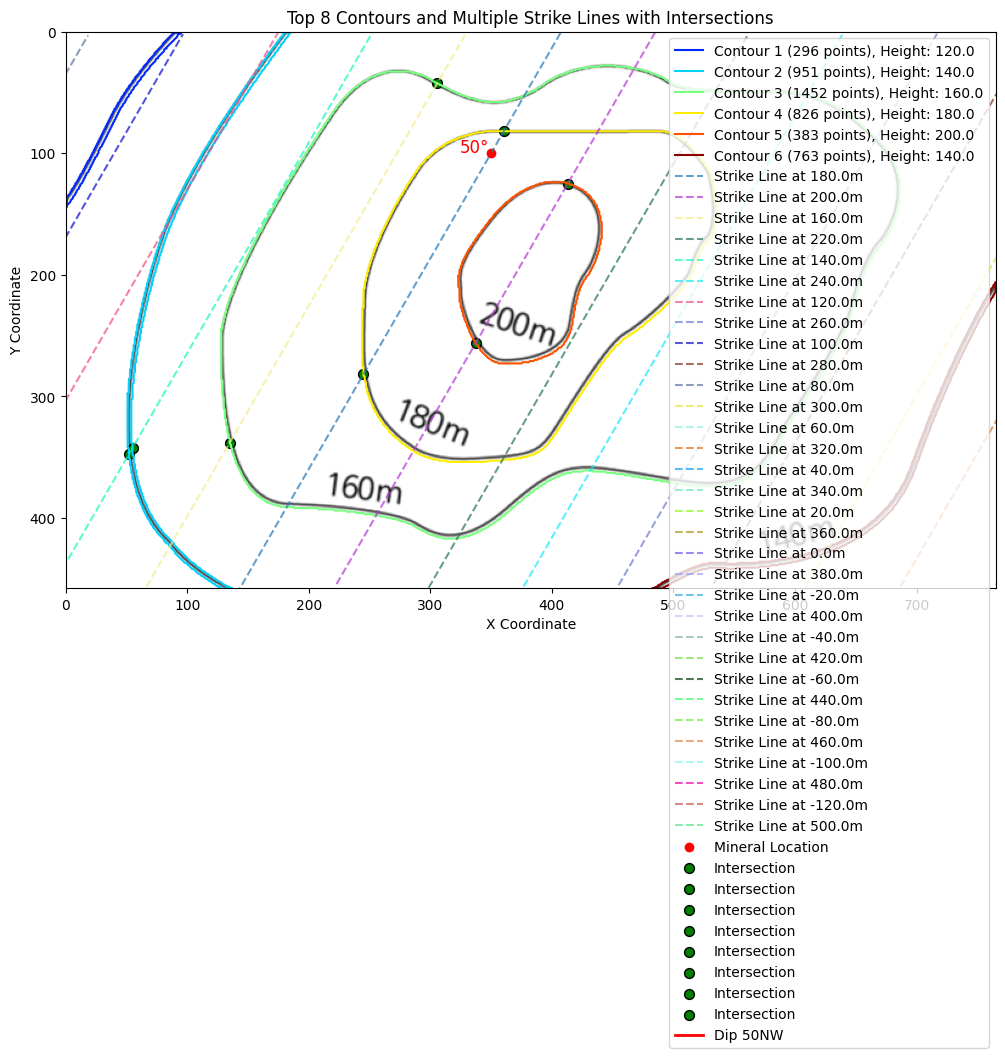

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import matplotlib.cm as cm

class ContourPlotter:
    def __init__(self, csv_filename, img_path):
        self.data = pd.read_csv(csv_filename)
        self.img = cv2.imread(img_path)  # 이미지 불러오기
        self.img_width, self.img_height = self.img.shape[1], self.img.shape[0]
        self.contour_colors = plt.cm.jet(range(0, 256, 256 // self.data['Contour'].nunique()))
        
        # 사용자 입력 속성 초기화
        self.m_x = None
        self.m_y = None
        self.m_h = None
        self.direction = None
        self.azimuth = None
        self.slope = None
        self.x_line = None
        self.y_line = None
        self.dip_angle = None
        self.dip_theta = None
        self.dip_input = None
        self.del_y = None
        self.contour_heights = {}
        self.strike_lines = []
    
    def initialize_and_display_contours(self):
        """등고선을 초기화하고 시각화하여 높이를 설정하도록 표시합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
        
        contour_groups = self.data.groupby('Contour')
        for contour_num, group in contour_groups:
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num}')
        
        plt.title("Contours - Assign Heights to Each Contour")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()
    
    def get_contour_heights(self):
        """사용자로부터 각 등고선의 고도를 입력받습니다."""
        unique_contours = self.data['Contour'].unique()
        for contour_num in unique_contours:
            while True:
                try:
                    height = float(input(f"등고선 {contour_num}의 고도를 입력하세요: "))
                    self.contour_heights[contour_num] = height
                    break
                except ValueError:
                    print("잘못된 입력입니다. 숫자 값을 입력하세요.")
    
    def get_user_input(self):
        """사용자로부터 광물 위치, 주향 및 경사 정보를 입력받습니다."""
        while True:
            try:
                self.m_x = float(input("광물의 X 좌표를 입력하세요: "))
                self.m_y = float(input("광물의 Y 좌표를 입력하세요: "))
                self.m_h = float(input("광물의 고도를 입력하세요: "))
                self.direction = input("주향을 입력하세요 (예: N30E): ").strip()
                self.dip_input = input("경사를 입력하세요 (예: 50SE, 30NW): ").strip()
                self.k = float(input("주향선 간격 비율(k)을 입력하세요: "))
                self.h = float(input("등고선 간격을 입력하세요: "))

                print("\n입력된 값 확인:")
                print(f"광물의 X 좌표: {self.m_x}")
                print(f"광물의 Y 좌표: {self.m_y}")
                print(f"광물의 고도: {self.m_h}")
                print(f"주향: {self.direction}")
                print(f"경사: {self.dip_input}")
                print(f"주향선 간격 비율 (k): {self.k}")
                print(f"등고선 간격 (h): {self.h}")
                break
            except ValueError:
                print("잘못된 입력입니다. 숫자 값을 입력하거나 올바른 형식으로 입력하세요.")

        # 주향 및 경사 계산
        self.azimuth = 360 - self.parse_azimuth(self.direction)
        self.slope = math.tan(math.radians(self.azimuth)) if self.azimuth % 180 != 0 else None
        self.dip_angle, dip_direction = self.parse_dip(self.dip_input)
        perpendicular_azimuth = (self.azimuth + 90) if dip_direction in ("N", "E") else (self.azimuth - 90)
        self.dip_theta = math.radians(perpendicular_azimuth % 360)

        # del_y 계산 (경사에 따른 주향선의 평행 이동 거리)
        self.del_y = (1 / np.cos(math.radians(self.azimuth))) * (self.h / np.tan(math.radians(self.dip_angle))) / self.k

    def parse_azimuth(self, direction):
        """주향을 방위각(degrees)으로 변환하는 함수"""
        direction = direction.upper().strip()
        if "N" in direction:
            base_azimuth = 90
            if "E" in direction:
                angle = int(direction.replace("N", "").replace("E", ""))
                return base_azimuth - angle
            elif "W" in direction:
                angle = int(direction.replace("N", "").replace("W", ""))
                return base_azimuth + angle
            else:
                return base_azimuth
        elif "S" in direction:
            base_azimuth = 270
            if "E" in direction:
                angle = int(direction.replace("S", "").replace("E", ""))
                return base_azimuth + angle
            elif "W" in direction:
                angle = int(direction.replace("S", "").replace("W", ""))
                return base_azimuth - angle
        elif "W" in direction:
            return 0
        raise ValueError("유효하지 않은 주향입니다. 예: EW, N30E, S45W 등")

    def parse_dip(self, dip_input):
        """경사 각도와 방향을 파싱하는 함수"""
        dip_angle = int(''.join(filter(str.isdigit, dip_input)))
        dip_direction = ''.join(filter(str.isalpha, dip_input)).upper()
        return dip_angle, dip_direction

    def calculate_mineral_boundary(self):
        """광물 경계선을 계산하여 x, y 좌표 배열을 생성합니다."""
        # x 좌표 범위를 넓게 설정하여 이미지 경계를 넘어가는 주향선 표시
        x = np.linspace(-self.img_width, 2 * self.img_width, 1000)
        
        if self.slope is not None:
            y = self.slope * x + (self.m_y - self.slope * self.m_x)
        else:  # 수직선의 경우
            y = np.full_like(x, self.m_y)
        
        self.x_line, self.y_line = x, y  # 이미지 경계에 관계 없이 전체 범위 사용
        self.strike_lines.append((self.x_line, self.y_line, self.m_h))
    
    def get_top_contours(self, num=8):
        """상위 num개의 등고선 번호를 반환합니다."""
        contours_with_counts = [(contour_num, len(group)) for contour_num, group in self.data.groupby('Contour')]
        sorted_contours = sorted(contours_with_counts, key=lambda x: x[1], reverse=True)
        return [contour_num for contour_num, _ in sorted_contours[:num]]
    
    def draw_parallel_strike_lines(self):
        """주향 방향을 따라 평행하게 이동한 다수의 주향선을 플롯합니다."""
        i = 1
        while True:
            # Positive direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h - i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h + i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_positive = self.y_line + i * self.del_y
            mask = (y_shifted_positive >= 0) & (y_shifted_positive <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_positive[mask], current_height))

            # Negative direction
            if "S" in self.dip_input:  # 남쪽 경사
                current_height = self.m_h + i * self.h
            elif "N" in self.dip_input:  # 북쪽 경사
                current_height = self.m_h - i * self.h
            else:
                current_height = self.m_h  # 기본값

            y_shifted_negative = self.y_line - i * self.del_y
            mask = (y_shifted_negative >= 0) & (y_shifted_negative <= self.img_height)
            if not mask.any():
                break
            self.strike_lines.append((self.x_line[mask], y_shifted_negative[mask], current_height))
            i += 1

          
    def calculate_intersections(self):
        """같은 고도의 주향선과 등고선의 교차점을 계산하여 출력합니다."""
        self.intersections = []  # 클래스 멤버 변수로 변경
        tolerance = 1e-5  # 작은 오차 허용 범위 설정

        for contour_num, group in self.data.groupby('Contour'):
            # 해당 등고선의 고도
            if contour_num not in self.contour_heights:
                continue
            contour_height = self.contour_heights[contour_num]

            x_coords = group['X'].values
            y_coords = group['Y'].values

            for x_line, y_line, strike_height in self.strike_lines:
                # 주향선의 높이가 등고선의 높이와 같을 때만 교차점 계산
                if abs(contour_height - strike_height) < tolerance:
                    # 각 등고선과 주향선의 모든 교차점을 찾기
                    for i in range(len(x_coords) - 1):
                        for j in range(len(x_line) - 1):
                            x1, y1, x2, y2 = x_coords[i], y_coords[i], x_coords[i + 1], y_coords[i + 1]
                            x3, y3, x4, y4 = x_line[j], y_line[j], x_line[j + 1], y_line[j + 1]

                            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                            if abs(denom) < tolerance:
                                continue  # 거의 평행한 경우 교점 없음

                            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

                            # 교차점이 두 선분의 범위 내에 있는지 확인
                            if (min(x1, x2) - tolerance <= px <= max(x1, x2) + tolerance) and \
                            (min(y1, y2) - tolerance <= py <= max(y1, y2) + tolerance) and \
                            (min(x3, x4) - tolerance <= px <= max(x3, x4) + tolerance) and \
                            (min(y3, y4) - tolerance <= py <= max(y3, y4) + tolerance):
                                self.intersections.append((contour_num, px, py))
                                # 교차점 정보를 터미널에 출력
                                print(f"Intersection at contour {contour_num} (height {contour_height}), X = {px:.2f}, Y = {py:.2f}")

    def plot(self):
        """이미지, 등고선 및 광물 경계선을 플롯합니다."""
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))

        contour_groups = self.data.groupby('Contour')
        top_contours = self.get_top_contours()

        # 등고선 플롯 및 주향선과의 교점 찾기
        for contour_num, group in contour_groups:
            if contour_num not in top_contours:
                continue
            x_coords = group['X'].values
            y_coords = group['Y'].values
            color = self.contour_colors[contour_num % len(self.contour_colors)]
            plt.plot(x_coords, y_coords, color=color, label=f'Contour {contour_num} ({len(x_coords)} points), Height: {self.contour_heights[contour_num]}')

        # 주향선 및 평행 주향선 그리기
        import random
        for idx, (x_line, y_line, height) in enumerate(self.strike_lines):
            random_color = (random.random(), random.random(), random.random())
            plt.plot(x_line, y_line, color=random_color, linestyle='--', alpha=0.7, label=f'Strike Line at {height}m')

        # 광물 위치 및 경사 방향 표시
        plt.scatter(self.m_x, self.m_y, color='red', label='Mineral Location')
       # 교차점 플롯 추가
        for contour_num, x, y in self.intersections:
            plt.scatter(x, y, color='green', s=50, edgecolor='black', label='Intersection')

        dip_x = self.m_x + 2 * math.cos(self.dip_theta)
        dip_y = self.m_y + 2 * math.sin(self.dip_theta)
        plt.plot([self.m_x, dip_x], [self.m_y, dip_y], color='red', linewidth=2, label=f'Dip {self.dip_input}')
        plt.text(dip_x, dip_y, f'{self.dip_angle}°', color='red', fontsize=12, ha='right')

        # 그래프 범위 설정 및 기타 설정
        plt.xlim([0, self.img_width])
        plt.ylim([self.img_height, 0])  # y축을 이미지 좌표계에 맞춰 반전
        plt.legend()
        plt.title('Top 8 Contours and Multiple Strike Lines with Intersections')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# 사용 예시
csv_filename = 'contour_data.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\past.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.draw_parallel_strike_lines()  # 평행 주향선 그리기
plotter.calculate_intersections()  # 교차점 계산
plotter.plot()


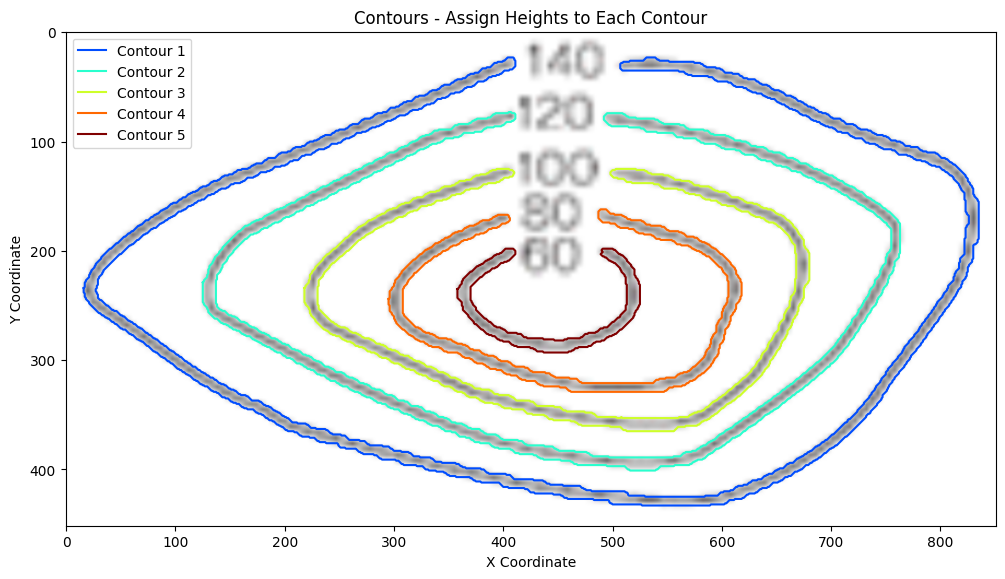

Intersection at contour 1 (height 140.0), X = 162.12, Y = 125.00
Intersection at contour 1 (height 140.0), X = 154.61, Y = 138.00
Intersection at contour 1 (height 140.0), X = 74.96, Y = 275.96
Intersection at contour 1 (height 140.0), X = 70.57, Y = 283.57
Intersection at contour 2 (height 120.0), X = 227.51, Y = 146.00
Intersection at contour 2 (height 120.0), X = 220.00, Y = 159.00
Intersection at contour 2 (height 120.0), X = 159.24, Y = 264.24
Intersection at contour 2 (height 120.0), X = 154.76, Y = 272.00
Intersection at contour 3 (height 100.0), X = 295.48, Y = 162.52
Intersection at contour 3 (height 100.0), X = 285.97, Y = 179.00
Intersection at contour 3 (height 100.0), X = 238.76, Y = 260.76
Intersection at contour 3 (height 100.0), X = 233.64, Y = 269.64
Intersection at contour 4 (height 80.0), X = 361.75, Y = 182.00
Intersection at contour 4 (height 80.0), X = 354.24, Y = 195.00
Intersection at contour 4 (height 80.0), X = 314.26, Y = 264.26
Intersection at contour 4 (hei

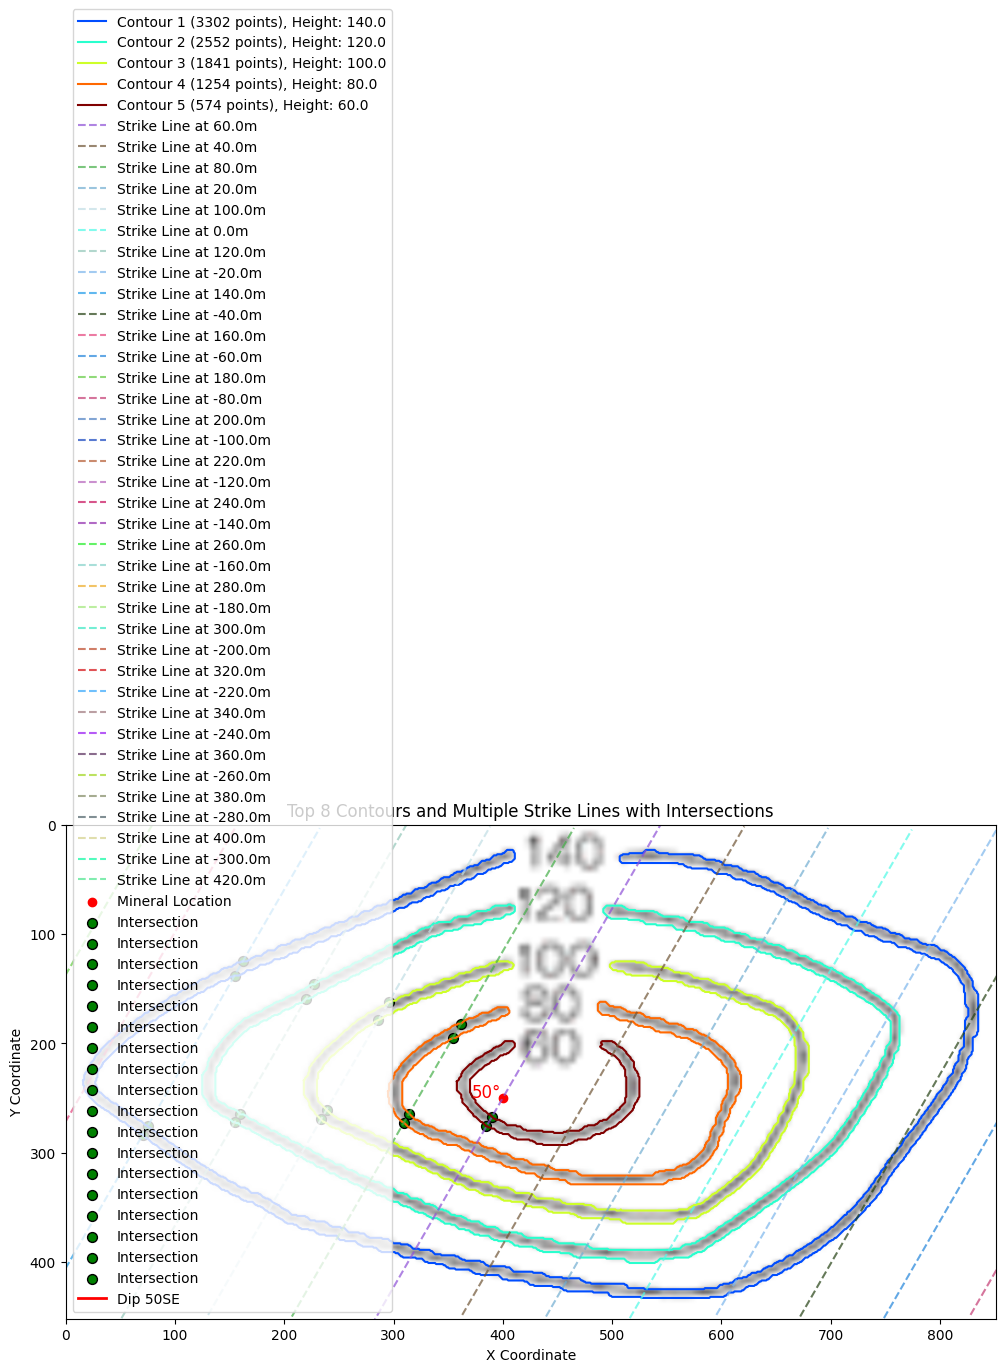

In [6]:
# 사용 예시
csv_filename = 'contour_data_test2.csv'
img_path = r'D:\W00Y0NG\PRGM2\2024RNE_GEO\test2.png'  # 실제 이미지 경로로 변경
plotter = ContourPlotter(csv_filename, img_path)
plotter.initialize_and_display_contours()  # 등고선 초기화 및 표시
plotter.get_contour_heights()  # 사용자로부터 등고선 고도 입력 받기
plotter.get_user_input()  # 사용자로부터 입력 받기
plotter.calculate_mineral_boundary()  # 광물 경계선 계산
plotter.draw_parallel_strike_lines()  # 평행 주향선 그리기
plotter.calculate_intersections()  # 교차점 계산
plotter.plot()